# Diferenciacion automatica

Supongamos que necesitamos encontrar derivadas de la funcion $F(x)=(5x+1)^2$

Si descomponemos la funci\'on $F(x)=f(g(x))$, donde $f(x)=x^2$ y $g(x)=5x+1$ entonces podemos calcular la derivada de $\frac{\partial F(x)}{\partial x}$ como:

\begin{align}
\frac{\partial F(x)}{\partial x}=\frac{\partial f(g(x))}{\partial x} \times \frac{\partial g(x)}{\partial x}
\end{align}

In [5]:
from autograd import grad
from autograd.core import primitive
import autograd.numpy as np

def F(x):
    return (5*x+1)**2

grad_F = grad(F)

print ('F(X) : %.6f'%F(0.0))
print ('dF/dx : %.6f'%grad_F(0.0))

F(X) : 1.000000
dF/dx : 10.000000


# Redes Neuronales

Ahora en el contexto del aprendizaje automatico, queremos eoncontrar derivadas parciales de una funcion objetivo con respecto a los parametros del modelo. En el caso de problemas de clasificacion binaria multi-variable contamos con datos de entrada $\textbf X=(\mathbf x_1,\ldots,\mathbf x_n)$ y sus correspondientes etiquetas $\textbf y=(y_1,\ldots,y_n)$.

Para cada tupla $(x_i,y_i)$ podemos establecer la siguiente relacion lineal:

\begin{align}
\text{log}\left(\frac{p( C=1 \vert \mathbf x_i )}{p(C=0 \vert \mathbf x_i )} \right)&=w_0+\sum_{j=1}^{n} w_j\,x_{ij}\\
&=\mathbf w^T \mathbf x_i
\end{align}  

Al mismo tiempo , podemos obtener las probabilidades condicionales para cada clase:

\begin{align}
p(C=1\vert \textbf x_i)&= \phi(\mathbf w^T \mathbf x_i)=\frac{\text{exp}(\mathbf w^T \mathbf x_i)}{1+\text{exp}(\mathbf w^T \mathbf x_i)}
\end{align} 

Donde $\phi(\cdot)$ es la llamada función sigmoide.

La funcion sigmoide convierte cualquier entrada $\mathbf w^T \mathbf x_i \in [-\inf,\inf]$ hacia el intervalo $(0,1)$, por lo tanto podemos utilizar la funcion de verosimilitud de la distribucion de Bernoulli para comparar las probabilidad de clase con las etiquetas binarias:

\begin{align}
p(\textbf y, \textbf X,\mathbf w)= \prod_{i=1}^N (\phi(\mathbf w^T \mathbf x_i))^y_i \times (1-\phi(\mathbf w^T \mathbf x_i))^{1-y_i}
\end{align}

Ahora queremos obtener los parametros $\hat{\mathbf w}$ que maximicen la verosimilitud $p(\textbf y, \textbf X,\mathbf w)$. Dado que la funcion logaritmo es monotona en todo el dominio $[-\inf,\inf]$ utilizamos $\operatorname{log} p(\textbf y, \textbf X,\mathbf w)$ como funcion objetivo (log-loss):

\begin{align}
L(\mathbf w)=\sum_{i=1}^N (y_i \operatorname{log} \phi(\mathbf w^T \mathbf x_i)) + ({1-y_i}) \operatorname{log} (1-\phi(\mathbf w^T \mathbf x_i))
\end{align}

Ahora que tenemos definida una funcion objetivo, podemos evaluar iterativamente los pesos $w$ escogiendo la direccion de maximo crecimiento (gradiente).

\begin{align}
\mathbf w^{j+1}= \mathbf  w^j-\eta \frac{\partial L(\mathbf w)}{\partial \mathbf w}
\end{align}

Donde $\eta > 0$ es un factor de descuento o tasa de aprendizaje.

In [24]:
from __future__ import absolute_import
from __future__ import print_function
from builtins import range
import autograd.numpy as np
from autograd import grad
from autograd.test_util import check_grads
import matplotlib.pyplot as plt

def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

def logistic_predictions(weights, inputs):
    # Outputs probability of a label being true according to logistic model.
    return sigmoid(np.dot(inputs, weights))

def training_loss(weights):
    # Training loss is the negative log-likelihood of the training labels.
    preds = logistic_predictions(weights, inputs)
    label_probabilities = np.log(preds) * targets + np.log((1 - preds)) * (1 - targets)
    return -np.sum(label_probabilities)

# Build a toy dataset.
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = np.array([True, True, False, True])

# Build a function that returns gradients of training loss using autograd.
training_gradient_fun = grad(training_loss)

# Check the gradients numerically, just to be safe.
weights = np.array([0.0, 0.0, 0.0])
check_grads(training_loss, modes=['rev'])(weights)


Iteration : 0, Trained loss: 0.0779122937305383
Iteration : 100, Trained loss: 0.05365533781925247
Iteration : 200, Trained loss: 0.04087498910681688
Iteration : 300, Trained loss: 0.0329956366328437
Iteration : 400, Trained loss: 0.027655550712034484
Iteration : 500, Trained loss: 0.02379920008417367
Iteration : 600, Trained loss: 0.020884407082251897
Iteration : 700, Trained loss: 0.0186042639953399
Iteration : 800, Trained loss: 0.016772075524082972
Iteration : 900, Trained loss: 0.015267781396225246


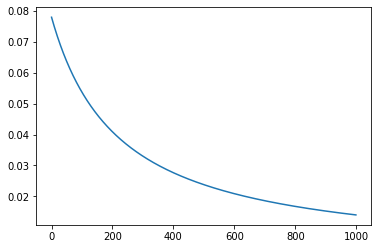

In [29]:
loss_history=[]
eta=0.1
iterations=1000
for i in range(iterations):
    weights -= training_gradient_fun(weights) * eta
    loss_history.append(training_loss(weights))
    if i%(iterations/10)==0:
        print("Iteration : {0}, Trained loss: {1}".format(i,training_loss(weights)))
        


plt.plot(loss_history)
plt.show()